In [1]:
import torch
import transformers
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from transformers.tokenization_bert_japanese import BertJapaneseTokenizer
from transformers import DistilBertForSequenceClassification
from transformers import BertModel
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import re
import emoji
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from collections import defaultdict

In [2]:
RANDOM_SEED = 17
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
df = pd.read_csv(r"C:/Users/YangWang/Desktop/Text_Classifier_for_UtaPass_and_KKBOX/data/all_20200423.csv", 
                 usecols=["content", "rating"])
df.head()

,rating,content
0,2,アプリをダウンロードしたばかりで、バックグラウンドで聴いています。星の理由は曲のダウンロード...
1,5,NaN
2,5,ダウンロードはネットが必要ですが、その後はオフラインで聞くことが出来てとても便利です。 オフ...
3,4,広告をあまり見たくない方は、下のタブにある本人→右上のアイコンを押すと、30秒間の広告を見る...
4,1,音楽をダウンロードしようと思ったら、ダウンロードマークが無くて、追加しかない状態だった。その...


In [4]:
def give_emoji_free_text(text):
    allchars = [string for string in text]
    emoji_list = [c for c in allchars if c in emoji.UNICODE_EMOJI]
    cleaned_text = ' '.join([str for str in text.split() if not any(i in str for i in emoji_list)])
    return cleaned_text

def clean_text(text):
    # Remove emoji
    text = give_emoji_free_text(text)
    # Remove punctuation
    text = re.sub(r'[^\w\d\s]+', '', text)
    # Remove digits
    text = ''.join([i for i in text if not i.isdigit()])
    return text

In [5]:
df.dropna(inplace=True, axis=0)
df["content"] = df["content"].map(str)
df["content"] = df["content"].apply(clean_text)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13861 entries, 0 to 13922
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   rating   13861 non-null  int64 
 1   content  13861 non-null  object
dtypes: int64(1), object(1)
memory usage: 324.9+ KB


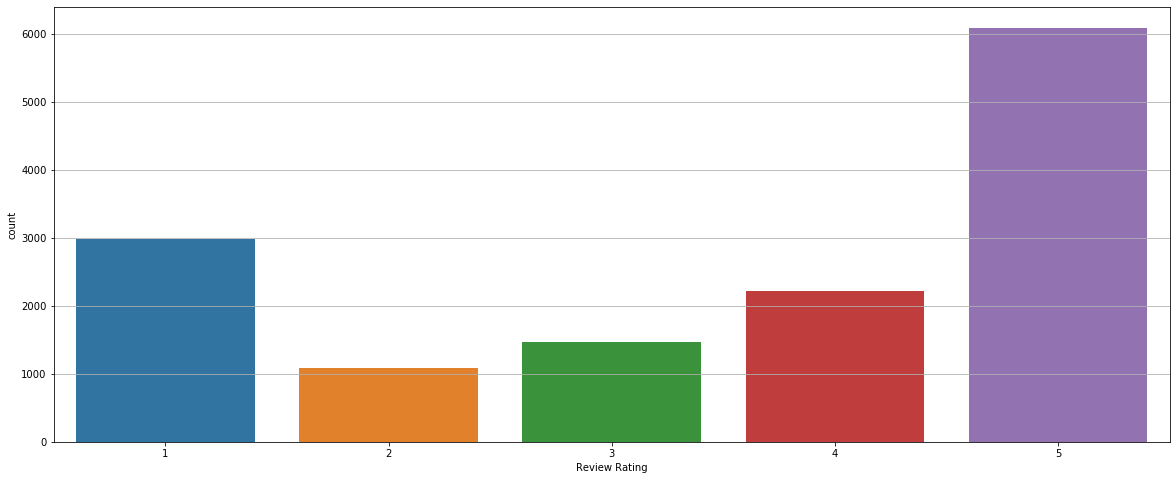

In [6]:
plt.figure(figsize=(20, 8))
sns.countplot(df.rating)
plt.xlabel("Review Rating")
plt.grid(axis="y")

In [7]:
def to_sentiment(rating):
    rating = int(rating)
    if rating <= 3: return 0
    else: return 1
    
df["rating"] = df["rating"].apply(to_sentiment)
class_name = ["negative", "positive"]
df.head()

,rating,content
0,0,アプリをダウンロードしたばかりでバックグラウンドで聴いています星の理由は曲のダウンロードが出...
2,1,ダウンロードはネットが必要ですがその後はオフラインで聞くことが出来てとても便利です オフライ...
3,1,広告をあまり見たくない方は下のタブにある本人右上のアイコンを押すと秒間の広告を見る代わりに時...
4,0,音楽をダウンロードしようと思ったらダウンロードマークが無くて追加しかない状態だったその上どれ...
5,1,個人の感想ですが色々な曲が聞けて使いやすいしとても便利なアプリだと思います ですが歌詞が表示...


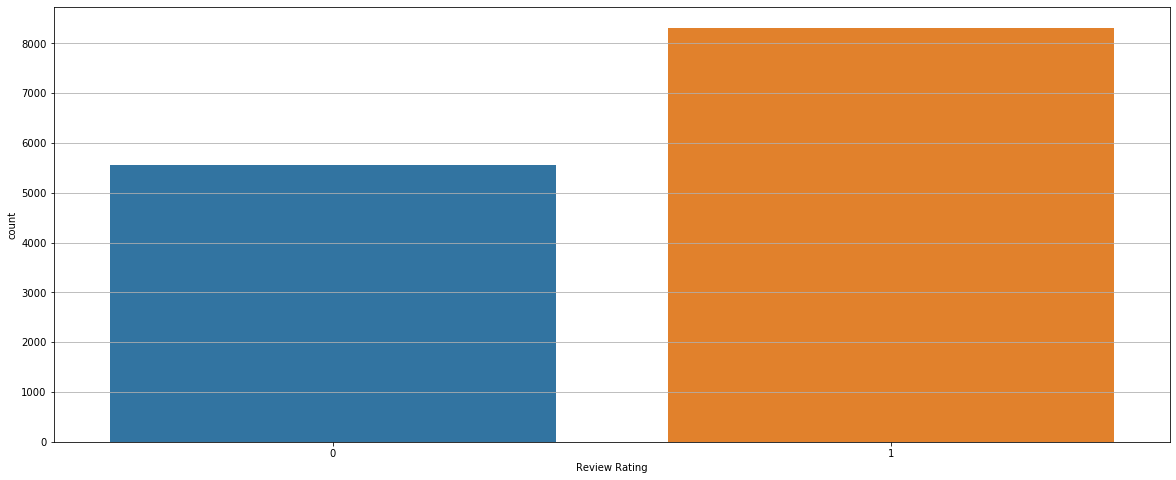

In [8]:
plt.figure(figsize=(20, 8))
sns.countplot(df.rating)
plt.xlabel("Review Rating")
plt.grid(axis="y")

In [9]:
# There is some other options:
# 1. bert-base-japanese
# 2. bert-base-japanese-whole-word-masking
# 3. bert-base-japanese-char
# 4. bert-base-japanese-char-whole-word-masking

PRE_TRAINED_MODEL_NAME = 'bert-base-japanese-whole-word-masking'
tokenizer = BertJapaneseTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [10]:
sample_text = "ダウンロードはネットが必要ですが、その後はオフラインで聞くことが出来てとても便利です。"
tokens = tokenizer.tokenize(sample_text)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print("Sentence: {}\n".format(sample_text))
print("Tokens: {}\n".format(tokens))
print("Tokens IDs: {}\n".format(token_ids))

Sentence: ダウンロードはネットが必要ですが、その後はオフラインで聞くことが出来てとても便利です。

Tokens: ['ダウンロード', 'は', 'ネット', 'が', '必要', 'です', 'が', '、', 'その後', 'は', 'オフ', '##ライン', 'で', '聞く', 'こと', 'が', '出来', 'て', 'とても', '便利', 'です', '。']

Tokens IDs: [7852, 9, 1920, 14, 727, 2992, 14, 6, 366, 9, 4838, 2716, 12, 10317, 45, 14, 1380, 16, 8567, 15249, 2992, 8]



In [11]:
print("[CLS] ID: ", tokenizer.cls_token_id)
print("[SEP] ID: ", tokenizer.sep_token_id)
print("[PAD] ID: ", tokenizer.pad_token_id)
print("[UNK] ID: ", tokenizer.unk_token_id)

[CLS] ID:  2
[SEP] ID:  3
[PAD] ID:  0
[UNK] ID:  1


In [12]:
# Add special tokens
# ('[CLS]', 2), ('[SEP]', 3), ('[PAD]', 0), ('[UNK]', 1)

encoding = tokenizer.encode_plus(
    sample_text, 
    max_length=32, 
    add_special_tokens=True, 
    return_token_type_ids=False, 
    pad_to_max_length=True, 
    return_attention_mask=True, 
    return_tensors="pt")

In [13]:
encoding

{'input_ids': tensor([[    2,  7852,     9,  1920,    14,   727,  2992,    14,     6,   366,
             9,  4838,  2716,    12, 10317,    45,    14,  1380,    16,  8567,
         15249,  2992,     8,     3,     0,     0,     0,     0,     0,     0,
             0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         0, 0, 0, 0, 0, 0, 0, 0]])}

In [14]:
tokenizer.convert_ids_to_tokens(encoding["input_ids"][0])

['[CLS]',
 'ダウンロード',
 'は',
 'ネット',
 'が',
 '必要',
 'です',
 'が',
 '、',
 'その後',
 'は',
 'オフ',
 '##ライン',
 'で',
 '聞く',
 'こと',
 'が',
 '出来',
 'て',
 'とても',
 '便利',
 'です',
 '。',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

Text(0.5, 0, 'Sentence Length (after tokenized)')

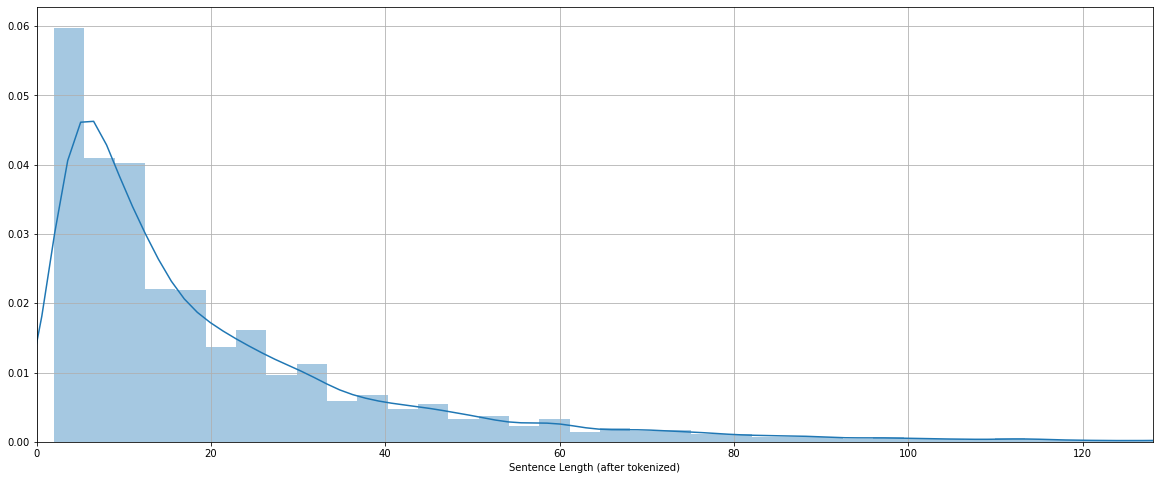

In [15]:
# Check tokenized sentence length in whole dataframe
tokens_length = []

for txt in df.content:
    tokens = tokenizer.encode(txt, max_length=512)
    tokens_length.append(len(tokens))
    
plt.figure(figsize=(20, 8))
sns.distplot(tokens_length)
plt.grid()
plt.xlim([0, 128])
plt.xlabel("Sentence Length (after tokenized)")

In [16]:
class ReviewDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        
        encoding = self.tokenizer.encode_plus(
            review, 
            max_length=self.max_len, 
            add_special_tokens=True, 
            return_token_type_ids=False, 
            pad_to_max_length=True, 
            return_attention_mask=True, 
            return_tensors="pt")
        
        return {
            "review_text": review, 
            "input_ids": encoding["input_ids"].flatten(), 
            "attention_mask": encoding["attention_mask"].flatten(), 
            "target": torch.tensor(target, dtype=torch.long)
        }

In [17]:
df_train, df_test = train_test_split(df, test_size=0.4, shuffle=True, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, shuffle=True, random_state=RANDOM_SEED)

print("Train Size: ", df_train.shape)
print("Validation Size: ", df_val.shape)
print("Test Size: ", df_test.shape)

Train Size:  (8316, 2)
Validation Size:  (2772, 2)
Test Size:  (2773, 2)


In [18]:
def create_dataloader(df, tokenizer, max_len, batch_size):
    dataset = ReviewDataset(
        reviews=df.content.to_numpy(), 
        targets=df.rating.to_numpy(), 
        tokenizer=tokenizer, 
        max_len=max_len)
    
    return DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=0)

In [19]:
BATCH_SIZE = 32
MAX_LEN = 128

train_dataloader = create_dataloader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_dataloader = create_dataloader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_dataloader = create_dataloader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [20]:
# Reference from https://github.com/BandaiNamcoResearchInc/DistilBERT-base-jp/blob/master/docs/GUIDE.md

data = next(iter(train_dataloader))
print("Input IDs shape:         ", data['input_ids'].shape)
print("Attention mask shape:    ", data['attention_mask'].shape)
print("Label shape:             ", data['target'].shape)

model = DistilBertForSequenceClassification.from_pretrained("checkpoint/DistilBERT-base-jp")
output, _ = model(
    input_ids=data['input_ids'],
    attention_mask=data['attention_mask'])
print("Output shape:            ", output.shape)

Input IDs shape:          torch.Size([32, 128])
Attention mask shape:     torch.Size([32, 128])
Label shape:              torch.Size([32])
Output shape:             torch.Size([32, 2])


In [21]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.distilbert_layer = DistilBertForSequenceClassification.from_pretrained("checkpoint/DistilBERT-base-jp")
        
    def forward(self, input_ids, attention_mask):
        output, _ = self.distilbert_layer(
            input_ids=input_ids, 
            attention_mask=attention_mask)
        return F.softmax(output, dim=1)

In [22]:
torch.cuda.empty_cache()
model = SentimentClassifier(len(class_name))
model.to(device)

SentimentClassifier(
  (distilbert_layer): DistilBertForSequenceClassification(
    (distilbert): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(32000, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0): TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
            )
            (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
   

In [23]:
EPOCHS = 4
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01, correct_bias=False)
total_steps = len(train_dataloader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0, 
    num_training_steps=total_steps)
loss_function = nn.CrossEntropyLoss().to(device)

In [24]:
def train_distilbert(model, data_loader, loss_function, optimizer, device, scheduler, n_examples):
    model = model.train()
    
    losses = []
    correct_predictions = 0
    true_pos, true_neg, false_pos, false_neg = 0, 0, 0, 0
    
    for data in data_loader:
        input_ids = data["input_ids"].to(device)
        attention_mask = data["attention_mask"].to(device)
        targets = data["target"].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_function(outputs, targets)
        
        for p, t in zip(preds, targets):
            if p == 1 and t == 1:
                true_pos += 1
            if p == 0 and t == 0:
                true_neg += 1
            if p == 1 and t == 0:
                false_pos += 1
            if p == 0 and t == 1:
                false_neg += 1
        
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
    recall = true_pos / float(true_pos + false_neg)
    precision = true_pos / float(true_pos + false_pos)
    f1 = 2 * precision * recall / (precision + recall)
    accuracy = (true_pos + true_neg) / float(n_examples)
        
    return accuracy, f1, np.mean(losses)

In [25]:
def eval_distilbert(model, data_loader, loss_function, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    true_pos, true_neg, false_pos, false_neg = 0, 0, 0, 0
    
    with torch.no_grad():
        for data in data_loader:
            input_ids = data["input_ids"].to(device)
            attention_mask = data["attention_mask"].to(device)
            targets = data["target"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_function(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            
            for p, t in zip(preds, targets):
                if p == 1 and t == 1:
                    true_pos += 1
                if p == 0 and t == 0:
                    true_neg += 1
                if p == 1 and t == 0:
                    false_pos += 1
                if p == 0 and t == 1:
                    false_neg += 1
                    
    recall = true_pos / float(true_pos + false_neg)
    precision = true_pos / float(true_pos + false_pos)
    f1 = 2 * precision * recall / (precision + recall)
    accuracy = (true_pos + true_neg) / float(n_examples)

    return accuracy, f1, np.mean(losses)

In [26]:
%%time

history = defaultdict(list)
best_f1 = 0
path = r"C:\Users\YangWang\Desktop\Text_Classifier_for_UtaPass_and_KKBOX\notebook\Modelling\BERT\checkpoint\best_bert.bin"

for epoch in range(EPOCHS):
    print("=" * 20)
    print("Epoch {}/{}".format(epoch+1, EPOCHS))
    
    train_acc, train_f1, train_loss = train_distilbert(
        model, train_dataloader, loss_function, optimizer, device, scheduler, len(df_train))
    
    print("    Train loss: {}".format(train_loss))
    print("    Train accuracy: {}".format(train_acc))
    print("    Train f1: {}\n".format(train_f1))
    
    val_acc, val_f1, val_loss = eval_distilbert(
        model, val_dataloader, loss_function, device, len(df_val))
    
    print("    Validation loss: {}".format(val_loss))
    print("    Validation accuracy: {}".format(val_acc))
    print("    Validation f1: {}\n".format(val_f1))
    
    history["train_f1"].append(train_f1)
    history["train_acc"].append(train_acc)
    history["train_loss"].append(train_loss)
    history["val_f1"].append(val_f1)
    history["val_acc"].append(val_acc)
    history["val_loss"].append(val_loss)
    
    
    if val_f1 > best_f1:
        torch.save(model.state_dict(), path)
        best_f1 = val_f1

Epoch 1/4
    Train loss: 0.5423873031368622
    Train accuracy: 0.7795815295815296
    Train f1: 0.8275797196877059

    Validation loss: 0.5187134441288038
    Validation accuracy: 0.7914862914862915
    Validation f1: 0.8447071466953251

Epoch 2/4
    Train loss: 0.4634065328882291
    Train accuracy: 0.8487253487253488
    Train f1: 0.8757162616083778

    Validation loss: 0.4719231217757039
    Validation accuracy: 0.8398268398268398
    Validation f1: 0.8700234192037473

Epoch 3/4
    Train loss: 0.44286967493020574
    Train accuracy: 0.8696488696488697
    Train f1: 0.8932860799369955

    Validation loss: 0.4694815730226451
    Validation accuracy: 0.8430735930735931
    Validation f1: 0.8720211827007943

Epoch 4/4
    Train loss: 0.431481994000765
    Train accuracy: 0.8828763828763829
    Train f1: 0.9039826498422713

    Validation loss: 0.4731981757728533
    Validation accuracy: 0.8365800865800865
    Validation f1: 0.8694148169501296

Wall time: 3min 26s


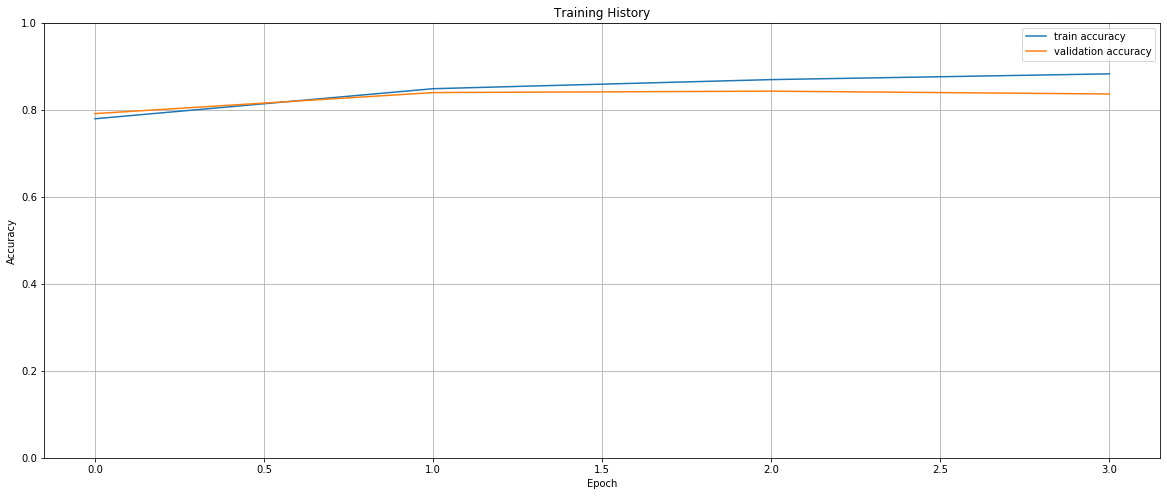

In [27]:
plt.figure(figsize=(20, 8))
plt.plot(history["train_acc"], label="train accuracy")
plt.plot(history["val_acc"], label="validation accuracy")
plt.title("Training History")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.ylim([0, 1])
plt.legend()
plt.grid()

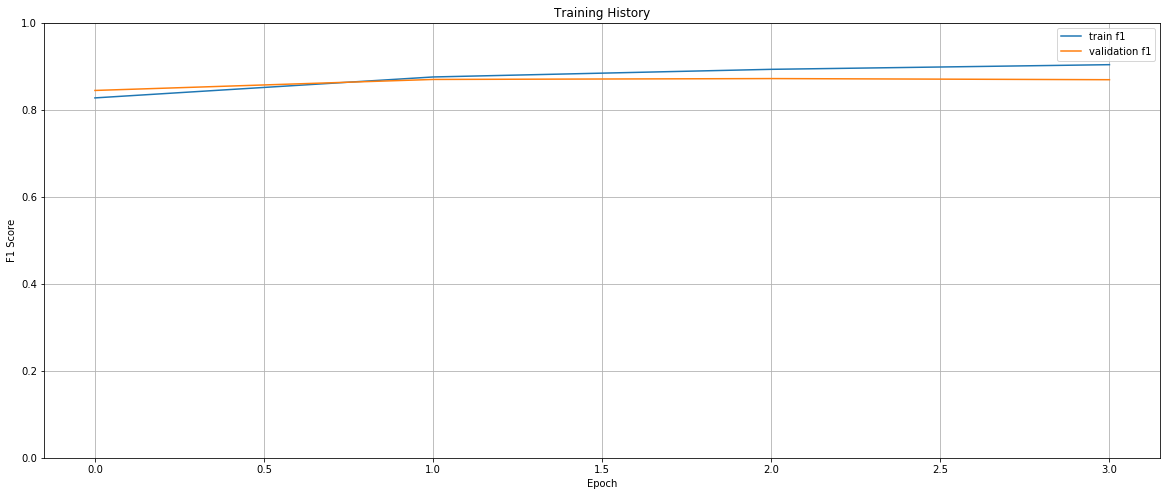

In [28]:
plt.figure(figsize=(20, 8))
plt.plot(history["train_f1"], label="train f1")
plt.plot(history["val_f1"], label="validation f1")
plt.title("Training History")
plt.ylabel("F1 Score")
plt.xlabel("Epoch")
plt.ylim([0, 1])
plt.legend()
plt.grid()

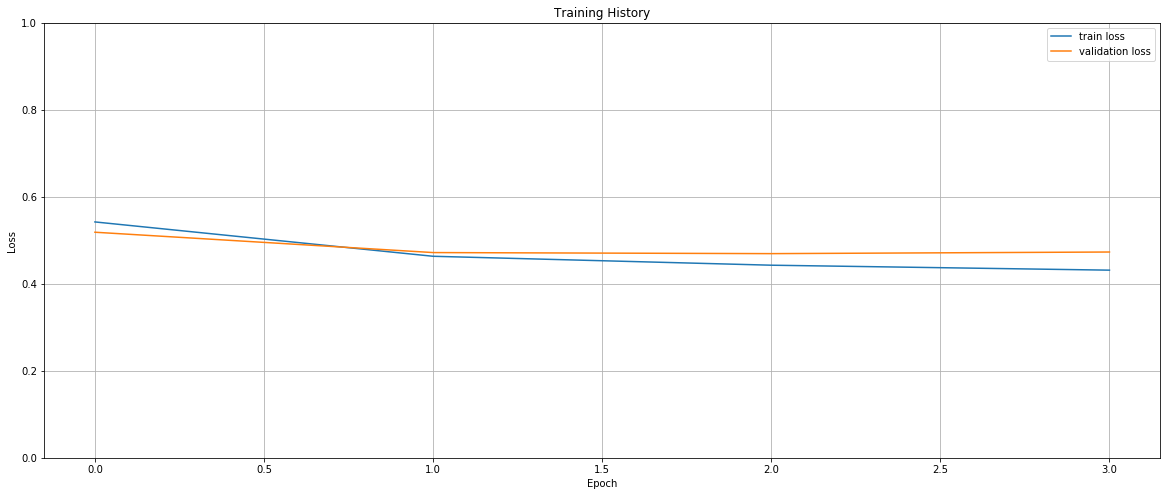

In [29]:
plt.figure(figsize=(20, 8))
plt.plot(history["train_loss"], label="train loss")
plt.plot(history["val_loss"], label="validation loss")
plt.title("Training History")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.ylim([0, 1])
plt.legend()
plt.grid()

In [31]:
test_acc, test_f1, _ = eval_distilbert(
    model, test_dataloader, loss_function, device, len(df_test))
print(test_acc)
print(test_f1)

0.852866931121529
0.8815331010452961


In [32]:
def get_predictions(model, data_loader):
    model = model.eval()
    
    reviews_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    
    with torch.no_grad():
        for data in data_loader:
            texts = data["review_text"]
            input_ids = data["input_ids"].to(device)
            attention_mask = data["attention_mask"].to(device)
            targets = data["target"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            
            reviews_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)
            
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    
    return reviews_texts, predictions, prediction_probs, real_values

In [33]:
y_reviews_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_dataloader)
print(classification_report(y_test, y_pred, target_names=class_name, zero_division=0))

              precision    recall  f1-score   support

    negative       0.84      0.77      0.81      1097
    positive       0.86      0.91      0.88      1676

    accuracy                           0.85      2773
   macro avg       0.85      0.84      0.84      2773
weighted avg       0.85      0.85      0.85      2773



In [34]:
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm, index=class_name, columns=class_name)
    plt.figure(figsize=(10, 8))
    hmap = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha="right")
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=0, ha="right")
    plt.xlabel("Predicted Sentiment")
    plt.ylabel("Target Sentiment")
    plt.show()

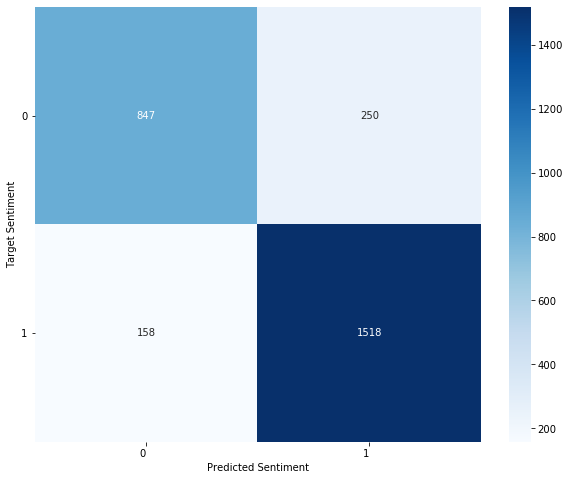

In [35]:
plot_confusion_matrix(y_test, y_pred)

In [ ]:
# model = SentimentClassifier(len(class_name))
# model.load_state_dict(torch.load("model_state_dict.bin", map_location=device))